## 1. Paths & Training Hyperparameters

In [2]:
import os, sys, math, time, random, itertools
from typing import Tuple, List, Dict
import timm

IMG_ROOT = r"C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_images"
TRAIN_CSV = r"C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_train_images.csv"
TEST_CSV  = r"C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_test_images.csv"
MASK_ROOT = IMG_ROOT.replace("png_images", "png_masks")  

OUT_DIR   = "./ConvNeXt+UNet(7,2,1)_Output"

IMG_SIZE  = 576  
EPOCHS    = 120       
BATCH     = 4         
LR        = 2e-4
SEED      = 42
VAL_RATIO = 0.20       
SAMPLER   = "off"  

print("IMG_ROOT:", IMG_ROOT)
print("TRAIN_CSV:", TRAIN_CSV)
print("TEST_CSV:", TEST_CSV)
print("OUT_DIR:", OUT_DIR)
print("EPOCHS/BATCH/LR:", EPOCHS, BATCH, LR)
print("VAL_RATIO/SAMPLER:", VAL_RATIO, SAMPLER)

IMG_ROOT: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_images
TRAIN_CSV: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_train_images.csv
TEST_CSV: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_test_images.csv
OUT_DIR: ./ConvNeXt+UNet(7,2,1)_Output
EPOCHS/BATCH/LR: 120 4 0.0002
VAL_RATIO/SAMPLER: 0.2 off


## 2. Imports & Device

In [29]:
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.transforms import functional as TF
from torchvision.transforms import InterpolationMode
import torchvision

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score,
                             confusion_matrix, roc_curve, precision_recall_curve)

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({"figure.dpi": 110})

def set_seed(seed: int = 42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(SEED)
print(f"Using device: {device} | AMP: {'on' if device.type=='cuda' else 'off'}")

Using device: cuda | AMP: on


## 3. Read CSVs & Quick Preview

In [30]:
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

display(train_df.head(8))
display(test_df.head(8))

print("Train shape:", train_df.shape, "Columns:", list(train_df.columns))
print("Test  shape:", test_df.shape, "Columns:", list(test_df.columns))

print("Train label distribution:", train_df["has_pneumo"].value_counts().to_dict())
print("Test  label distribution:", test_df["has_pneumo"].value_counts().to_dict())

,new_filename,ImageId,has_pneumo
0,0_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,0
1,1_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,0
2,2_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,1
3,3_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,1
4,4_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.1314.151787516...,1
5,5_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.11364.15178752...,0
6,6_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.4541.151787518...,0
7,7_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.4440.151787518...,1


,new_filename,ImageId,has_pneumo
0,0_test_1_.png,1.2.276.0.7230010.3.1.4.8323329.5797.151787519...,1
1,1_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.5798.151787519...,0
2,2_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.5799.151787519...,0
3,3_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.580.1517875163...,0
4,4_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.5800.151787519...,0
5,5_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.5801.151787519...,0
6,6_test_1_.png,1.2.276.0.7230010.3.1.4.8323329.5802.151787519...,1
7,7_test_1_.png,1.2.276.0.7230010.3.1.4.8323329.5803.151787519...,1


Train shape: (10675, 3) Columns: ['new_filename', 'ImageId', 'has_pneumo']
Test  shape: (1372, 3) Columns: ['new_filename', 'ImageId', 'has_pneumo']
Train label distribution: {0: 8296, 1: 2379}
Test  label distribution: {0: 1082, 1: 290}


## 4. Full-path Resolution & Dataset 

In [31]:
def resolve_full_paths(df: pd.DataFrame, img_root: str) -> pd.DataFrame:
    df = df.copy()
    def _resolve(row):
        name = str(row["new_filename"])
        name_png = name if name.lower().endswith(".png") else f"{name}.png"
        p1 = os.path.join(img_root, name_png)
        if os.path.exists(p1):
            return p1
        # fallback: ImageId.png
        alt = os.path.join(img_root, f"{row['ImageId']}.png")
        return alt if os.path.exists(alt) else p1
    df["full_path"] = df.apply(_resolve, axis=1)
    return df

train_df = resolve_full_paths(train_df, IMG_ROOT)
test_df  = resolve_full_paths(test_df,  IMG_ROOT)

missing_train = (~train_df["full_path"].apply(os.path.exists)).sum()
missing_test  = (~test_df["full_path"].apply(os.path.exists)).sum()
print(f"Missing files — Train: {missing_train} | Test: {missing_test}")

class PandasImageDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["full_path"]).convert("L")
        if self.transform: img = self.transform(img)
        y = int(row["has_pneumo"])
        return img, y
    
class JointImageMaskTransform:
    def __init__(self, out_size=IMG_SIZE):
        self.out_size = out_size

    def __call__(self, img, mask):
        # Resize + RandomResizedCrop + RandomHorizontalFlip + ToTensor + Normalize
        resize_to = int(self.out_size * 1.1)
        img  = TF.resize(img,  (resize_to, resize_to), interpolation=InterpolationMode.BILINEAR)
        mask = TF.resize(mask, (resize_to, resize_to), interpolation=InterpolationMode.NEAREST)

        i, j, h, w = torchvision.transforms.RandomResizedCrop.get_params(
            img,
            scale=(0.8, 1.0),
            ratio=(0.9, 1.1)
        )
        img  = TF.resized_crop(img,  i, j, h, w, (self.out_size, self.out_size),
                               interpolation=InterpolationMode.BILINEAR)
        mask = TF.resized_crop(mask, i, j, h, w, (self.out_size, self.out_size),
                               interpolation=InterpolationMode.NEAREST)

        if random.random() < 0.5:
            img  = TF.hflip(img)
            mask = TF.hflip(mask)

        img  = TF.to_tensor(img)               # [1,H,W], [0,1]
        img  = TF.normalize(img, [0.5], [0.25])

        mask = TF.to_tensor(mask)              # [1,H,W], [0,1]
        mask = (mask > 0.5).float()            # Binarize

        return img, mask

class PandasImageMaskDataset(Dataset):
    def __init__(self, df: pd.DataFrame, mask_root: str, joint_transform: JointImageMaskTransform):
        self.df = df.reset_index(drop=True)
        self.mask_root = mask_root
        self.joint_transform = joint_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Images come from full_path
        img_path = row["full_path"]
        img = Image.open(img_path).convert("L")

        # Masks come from mask_root + basename
        basename = os.path.basename(img_path)
        mask_path = os.path.join(self.mask_root, basename)

        if not os.path.exists(mask_path):
            raise FileNotFoundError(f"Mask not found for {img_path} -> {mask_path}")

        mask = Image.open(mask_path).convert("L")

        img, mask = self.joint_transform(img, mask)

        y = float(row["has_pneumo"])
        return img, y, mask

Missing files — Train: 0 | Test: 0


In [32]:
os.makedirs(OUT_DIR, exist_ok=True)
EDA_DIR = os.path.join(OUT_DIR, "eda"); os.makedirs(EDA_DIR, exist_ok=True)

def eda_class_distribution(df: pd.DataFrame, label_col: str, out_path: str, title: str):
    counts = df[label_col].value_counts().sort_index()
    plt.figure(figsize=(6,4))
    xs = [str(int(x)) for x in counts.index.tolist()]
    ys = counts.values.astype(int)
    plt.bar(xs, ys)
    for i, y in enumerate(ys):
        plt.text(i, y, str(y), ha="center", va="bottom", fontsize=9)
    plt.title(f"Class Distribution — {title}")
    plt.xlabel("Label"); plt.ylabel("Count")
    plt.tight_layout(); plt.savefig(out_path); plt.show()

def eda_missing_files(df: pd.DataFrame, out_txt: str, title: str):
    missing_mask = ~df["full_path"].apply(os.path.exists)
    total = len(df); missing = missing_mask.sum()
    with open(out_txt, "w", encoding="utf-8") as f:
        f.write(f"Total rows: {total}\nMissing files: {missing}\n")
        if missing:
            f.write("First 50 missing examples:\n")
            f.write("\n".join(df.loc[missing_mask, "full_path"].head(50).tolist()))
    print(f"[{title}] Missing: {missing}/{total} — saved to {out_txt}")

def eda_sample_grid(df: pd.DataFrame, out_path: str, title: str, n_per_class: int = 8, size: int = 128):
    labels = sorted(df["has_pneumo"].unique().tolist())
    panels = []
    for lab in labels:
        subset = df[df["has_pneumo"] == lab]
        sample = subset.sample(min(n_per_class, len(subset)), random_state=0)
        panels.append(sample)

    cols = n_per_class; rows = len(labels)
    plt.figure(figsize=(cols*2, rows*2))
    idx = 1
    for r, panel in enumerate(panels):
        for _, row in panel.iterrows():
            fp = row["full_path"]
            plt.subplot(rows, cols, idx)
            try:
                img = Image.open(fp).convert("L").resize((size,size))
                plt.imshow(img, cmap="gray"); plt.axis("off")
            except Exception:
                plt.text(0.5,0.5,"missing",ha="center",va="center"); plt.axis("off")
            idx += 1
    plt.suptitle(f"Sample Grid — {title}", y=0.98)
    plt.tight_layout(); plt.savefig(out_path); plt.show()

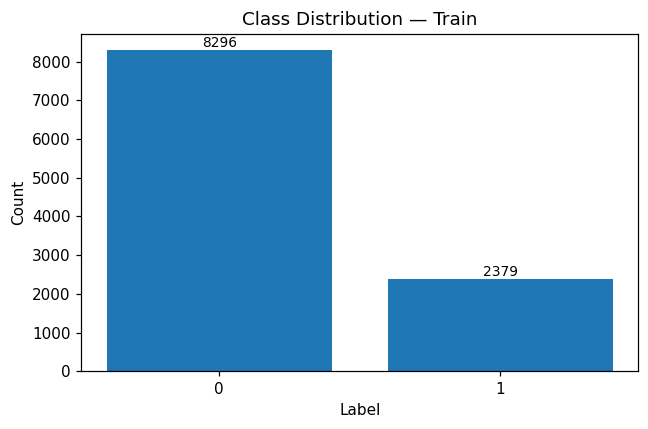

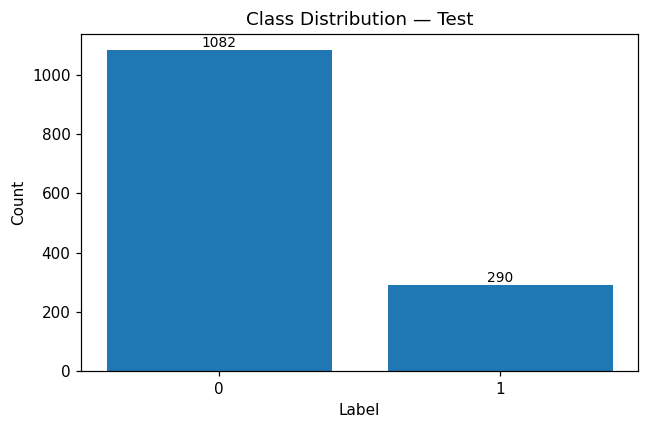

[Train] Missing: 0/10675 — saved to ./ConvNeXt+UNet_Output\eda\missing_train.txt
[Test] Missing: 0/1372 — saved to ./ConvNeXt+UNet_Output\eda\missing_test.txt


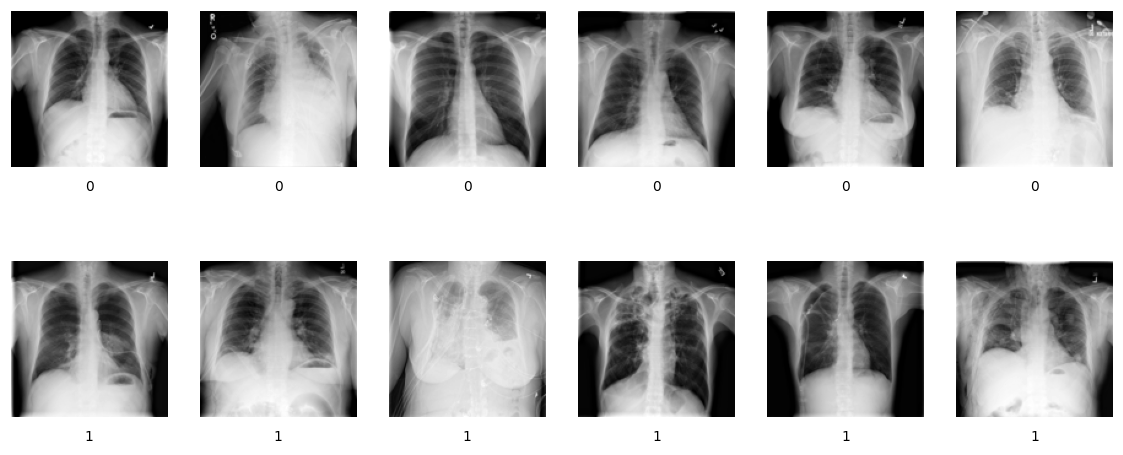

In [33]:
from pathlib import Path

eda_class_distribution(train_df, "has_pneumo", os.path.join(EDA_DIR, "class_dist_train.png"), "Train")
eda_class_distribution(test_df,  "has_pneumo", os.path.join(EDA_DIR, "class_dist_test.png"),  "Test")

eda_missing_files(train_df, os.path.join(EDA_DIR, "missing_train.txt"), "Train")
eda_missing_files(test_df,  os.path.join(EDA_DIR, "missing_test.txt"),  "Test")

def eda_sample_grid(df, out_path, split_name, n_per_class=6, size=128):
    label_col = "has_pneumo"
    path_col = "full_path" if "full_path" in df.columns else "filepath"

    classes = sorted(df[label_col].dropna().unique().tolist())
    nrows, ncols = len(classes), n_per_class
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2.2, nrows*2.4))
    if nrows == 1:
        axes = np.array([axes])

    for r, c in enumerate(classes):
        sub = df[df[label_col] == c]
        sampled = sub.sample(n=min(n_per_class, len(sub)), random_state=42) if len(sub) > 0 else sub
        sampled = sampled.reset_index(drop=True)

        for i in range(ncols):
            ax = axes[r, i]
            ax.set_axis_off()

            if i < len(sampled):
                row = sampled.iloc[i]
                img_path = str(Path(row[path_col]))
                try:
                    im = Image.open(img_path).convert("L")
                    if size:
                        im = im.resize((size, size))
                    ax.imshow(im, cmap="gray")
                except Exception:
                    ax.imshow(np.zeros((size, size)), cmap="gray")

                ax.text(0.5, -0.08, str(row[label_col]),
                        transform=ax.transAxes, ha="center", va="top", fontsize=9)
            else:
                ax.imshow(np.zeros((size, size)), cmap="gray")

    plt.subplots_adjust(hspace=0.6, wspace=0.05)
    plt.show()
    Path(os.path.dirname(out_path)).mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig)

eda_sample_grid(train_df, os.path.join(EDA_DIR, "sample_grid_train.png"), "Train", n_per_class=6, size=128)

In [34]:
# Stratified split
tr_df, val_df = train_test_split(train_df, test_size=VAL_RATIO,
                                 stratify=train_df["has_pneumo"], random_state=SEED)
# Oversampling
pos_df = tr_df[tr_df["has_pneumo"] == 1]
neg_df = tr_df[tr_df["has_pneumo"] == 0]

target_pos = n_neg = len(neg_df)
n_pos = len(pos_df)

factor    = target_pos // n_pos
remainder = target_pos % n_pos

pos_oversampled = pd.concat(
    [pos_df] * factor + [pos_df.sample(remainder, replace=True, random_state=SEED)],
    ignore_index=True
)

tr_df_bal = pd.concat([neg_df, pos_oversampled], ignore_index=True)
tr_df_bal = tr_df_bal.sample(frac=1.0, random_state=SEED).reset_index(drop=True)

print("Distribution of Train after oversampling:",
      (tr_df_bal["has_pneumo"] == 1).sum(), "pos,",
      (tr_df_bal["has_pneumo"] == 0).sum(), "neg")

# Using oversampled training set
tr_df = tr_df_bal


Distribution of Train after oversampling: 6637 pos, 6637 neg


In [ ]:
# Transforms
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.25]),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.25]),
])

# Joint transforms for image + mask (training set)
joint_train_tfms = JointImageMaskTransform(out_size=IMG_SIZE)

# Datasets
ds_train = PandasImageMaskDataset(tr_df, mask_root=MASK_ROOT, joint_transform=joint_train_tfms)
ds_val   = PandasImageDataset(val_df, transform=eval_tfms)
ds_test  = PandasImageDataset(test_df, transform=eval_tfms)

def make_weights_for_balancing(df: pd.DataFrame) -> np.ndarray:
    counts = df["has_pneumo"].value_counts().to_dict()
    return df["has_pneumo"].map(lambda y: 1.0 / counts[int(y)]).values.astype(np.float32)


if SAMPLER == "on":
    weights = make_weights_for_balancing(tr_df)
    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
    shuffle = False
else:
    sampler = None; shuffle = True

# DataLoaders
dl_train = DataLoader(ds_train, batch_size=BATCH, sampler=sampler, shuffle=shuffle,
                      num_workers=0, pin_memory=True)
dl_val   = DataLoader(ds_val, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)
dl_test  = DataLoader(ds_test, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

# Use eval dataset for train_eval
ds_train_eval = PandasImageDataset(tr_df, transform=eval_tfms)
dl_train_eval = DataLoader(
    ds_train_eval, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True
)


len(ds_train), len(ds_val), len(ds_test)

(13274, 2135, 1372)

In [36]:
import os
import numpy as np
from PIL import Image

first_pos_idx = 1  

row = tr_df.iloc[first_pos_idx]
img_path = row["full_path"]
basename = os.path.basename(img_path)

print("img_path:", img_path)
print("basename:", basename)

print("MASK_ROOT:", MASK_ROOT)
mask_path = os.path.join(MASK_ROOT, basename)
print("mask_path:", mask_path, "exists:", os.path.exists(mask_path))

mask_raw = Image.open(mask_path).convert("L")
mask_np = np.array(mask_raw)

print("raw mask shape:", mask_np.shape)
print("raw mask min/max:", mask_np.min(), mask_np.max())
print("raw mask positive pixels (>0):", (mask_np > 0).sum())


img_path: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_images\1602_train_1_.png
basename: 1602_train_1_.png
MASK_ROOT: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_masks
mask_path: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_masks\1602_train_1_.png exists: True
raw mask shape: (1024, 1024)
raw mask min/max: 0 255
raw mask positive pixels (>0): 1576


In [37]:
pos_indices = [i for i, v in enumerate(tr_df["has_pneumo"].values) if v == 1]
print("Positive sample number:", len(pos_indices))
first_pos_idx = pos_indices[0]

img, y, mask = ds_train[first_pos_idx]
print("index:", first_pos_idx)
print("label:", y)
print("mask shape:", mask.shape)
print("mask min/max:", mask.min().item(), mask.max().item())
print("mask positive pixels:", mask.sum().item())

Positive sample number: 6637
index: 1
label: 1.0
mask shape: torch.Size([1, 576, 576])
mask min/max: 0.0 1.0
mask positive pixels: 586.0


# ConvNeXt_V2
## DropPath (Random Depth)

In [38]:
def drop_path(x, drop_prob: float = 0.0, training: bool = False):
    if drop_prob == 0.0 or not training:
        return x
    keep_prob = 1.0 - drop_prob
    # Only sample along batch dimension, broadcast others
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    return x * random_tensor / keep_prob

class DropPath(nn.Module):
    def __init__(self, drop_prob: float = 0.0):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

## GRN

In [39]:
class GRN(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.gamma = nn.Parameter(torch.zeros(1, 1, 1, dim))
        self.beta = nn.Parameter(torch.zeros(1, 1, 1, dim))

    def forward(self, x):
        gx = torch.norm(x, p=2, dim=(1, 2), keepdim=True)                # [N,1,1,C]
        nx = gx / (gx.mean(dim=-1, keepdim=True) + 1e-6)                 # [N,1,1,C]
        return self.gamma * (x * nx) + self.beta + x                     # [N,H,W,C]

## LayerNorm2d

In [40]:
class LayerNorm2d(nn.Module):
    def __init__(self, num_channels: int, eps: float = 1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=1, keepdim=True)
        var = (x - mean).pow(2).mean(dim=1, keepdim=True)
        x = (x - mean) / torch.sqrt(var + self.eps)
        return self.weight.view(1, -1, 1, 1) * x + self.bias.view(1, -1, 1, 1)

## ConvNeXt_V2 block

In [41]:
class ConvNeXtV2Block(nn.Module):
    def __init__(
        self,
        dim: int,
        mlp_ratio: float = 4.0,
        drop_path: float = 0.0,
        layer_scale_init_value: float = 0.0,  
    ):
        super().__init__()
        # 7x7 depthwise convolution
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)

        # Do LayerNorm in channels_last format
        self.norm = nn.LayerNorm(dim, eps=1e-6)

        hidden_dim = int(dim * mlp_ratio)
        self.pwconv1 = nn.Linear(dim, hidden_dim)
        self.act = nn.GELU()
        self.grn = GRN(hidden_dim)
        self.pwconv2 = nn.Linear(hidden_dim, dim)

        # LayerScale
        if layer_scale_init_value > 0:
            self.gamma = nn.Parameter(layer_scale_init_value * torch.ones(dim))
        else:
            self.gamma = None

        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()

    def forward(self, x):
        shortcut = x  # [N, C, H, W]

        x = self.dwconv(x)

        # NCHW -> NHWC
        x = x.permute(0, 2, 3, 1)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.grn(x)
        x = self.pwconv2(x)

        if self.gamma is not None:
            x = self.gamma.view(1, 1, 1, -1) * x

        # NHWC -> NCHW
        x = x.permute(0, 3, 1, 2)

        x = shortcut + self.drop_path(x)
        return x

## U-Net Decoder Block

In [42]:
class DecoderBlock(nn.Module):
    def __init__(self, in_ch: int, skip_ch: int, out_ch: int):
        super().__init__()
        self.has_skip = skip_ch > 0

        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)

        self.conv1 = nn.Conv2d(in_ch + (skip_ch if skip_ch > 0 else 0),
                               out_ch, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_ch)

        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_ch)

        self.act   = nn.ReLU(inplace=True)

    def forward(self, x, skip=None):
        # Oversample
        x = self.upsample(x)

        if self.has_skip and skip is not None:
            if skip.shape[-2:] != x.shape[-2:]:
                skip = F.interpolate(skip, size=x.shape[-2:], mode="bilinear", align_corners=False)
            x = torch.cat([x, skip], dim=1)

        x = self.act(self.bn1(self.conv1(x)))
        x = self.act(self.bn2(self.conv2(x)))
        return x


## ConvNeXt_V2 tiny

In [43]:
class ConvNeXtV2Tiny(nn.Module):
    def __init__(
        self,
        in_chans: int = 3,
        num_classes: int = 1000,
        drop_path_rate: float = 0.0,
        layer_scale_init_value: float = 0.0, 
    ):
        super().__init__()

        # 4 deepths and dims for each stage
        depths = [3, 3, 9, 3]
        dims = [96, 192, 384, 768]

        self.downsample_layers = nn.ModuleList()
        self.stages = nn.ModuleList()

        # Constructing the stem: patch embedding with stride=4
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm2d(dims[0]),
        )
        self.downsample_layers.append(stem)

        # Constructing the blocks and downsampling layers for each stage
        total_blocks = sum(depths)
        dpr_values = torch.linspace(0, drop_path_rate, total_blocks).tolist()
        block_idx = 0

        for stage_idx in range(4):
            depth = depths[stage_idx]
            dim = dims[stage_idx]

            # Every stage begins with a downsampling layer (except the first)
            if stage_idx > 0:
                down = nn.Sequential(
                    LayerNorm2d(dims[stage_idx - 1]),
                    nn.Conv2d(dims[stage_idx - 1], dim, kernel_size=2, stride=2),
                )
                self.downsample_layers.append(down)

            blocks = []
            for i in range(depth):
                blocks.append(
                    ConvNeXtV2Block(
                        dim=dim,
                        mlp_ratio=4.0,
                        drop_path=dpr_values[block_idx + i],
                        layer_scale_init_value=layer_scale_init_value,
                    )
                )
            block_idx += depth

            self.stages.append(nn.Sequential(*blocks))

        # The last classification head: LN + Linear
        self.norm_head = nn.LayerNorm(dims[-1], eps=1e-6)
        self.head = (
            nn.Linear(dims[-1], num_classes) if num_classes > 0 else nn.Identity()
        )

    def forward_features(self, x):
        # Downsampling through stages
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)

        # Global average pooling and normalization
        x = x.mean(dim=[2, 3])
        x = self.norm_head(x)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)  # [N, num_classes]
        return x
    
class ConvNeXtV2TinyScratch(nn.Module):
    """
    ConvNeXtV2Tiny as encoder
    + U-Net decoder with skip connections
    + cls head (global pooling) + seg head
    """
    def __init__(
        self,
        in_chans: int = 1,
        n_classes: int = 1,
        drop_path_rate: float = 0.1,
    ):
        super().__init__()

        self.backbone = ConvNeXtV2Tiny(
            in_chans=in_chans,
            num_classes=n_classes,
            drop_path_rate=drop_path_rate,
            layer_scale_init_value=0.0,
        )

        # Channel dims at each stage of ConvNeXtV2Tiny
        dims = [96, 192, 384, 768]
        last_dim = dims[-1]   # The deepest 768

        # ===== Classification head =====
        self.cls_head = nn.Linear(last_dim, n_classes)

        # ===== U-Net decoder =====
        # encoder output: x1(1/4, 96), x2(1/8, 192), x3(1/16,384), x4(1/32,768)
        self.dec3 = DecoderBlock(in_ch=dims[3], skip_ch=dims[2], out_ch=dims[2])   # 1/32 -> 1/16
        self.dec2 = DecoderBlock(in_ch=dims[2], skip_ch=dims[1], out_ch=dims[1])   # 1/16 -> 1/8
        self.dec1 = DecoderBlock(in_ch=dims[1], skip_ch=dims[0], out_ch=dims[0])   # 1/8  -> 1/4
        self.dec0 = DecoderBlock(in_ch=dims[0], skip_ch=0,        out_ch=max(dims[0] // 2, 32))  # 1/4 -> 1/2

        # Segmentation head：convalution to 1 channel
        self.seg_head = nn.Conv2d(max(dims[0] // 2, 32), 1, kernel_size=1)

    def forward_backbone_pyramid(self, x):
        """
        Return feature pyramid from backbone
        x1: 1/4,  x2: 1/8,  x3: 1/16, x4: 1/32
        """
        feats = []
        for i in range(4):
            x = self.backbone.downsample_layers[i](x)
            x = self.backbone.stages[i](x)
            feats.append(x)
        return feats  # [x1, x2, x3, x4]

    def forward(self, x):
        # ---- Encoder ----
        x1, x2, x3, x4 = self.forward_backbone_pyramid(x)

        # ---- Classification branch----
        gap = x4.mean(dim=[2, 3])          # [B, C4]
        gap = self.backbone.norm_head(gap) 
        cls_logits = self.cls_head(gap)    # [B, 1]
        cls_logits = cls_logits.squeeze(1) # [B]

        # ---- U-Net Decoder + Segmentation head ----
        d3 = self.dec3(x4, x3)    # 1/32 -> 1/16
        d2 = self.dec2(d3, x2)    # 1/16 -> 1/8
        d1 = self.dec1(d2, x1)    # 1/8  -> 1/4
        d0 = self.dec0(d1, None)  # 1/4  -> 1/2

        seg_logits = self.seg_head(d0)  # [B,1,H_dec,W_dec]

        seg_logits = F.interpolate(
            seg_logits,
            size=x.shape[-2:],
            mode="bilinear",
            align_corners=False,
        )

        return cls_logits, seg_logits

model = ConvNeXtV2TinyScratch(in_chans=1, n_classes=1, drop_path_rate=0.1).to(device)

## Loss：Tversky + Focal

### Tversky Loss

In [44]:
# Weights initialization
LAMBDA_SEG = 0.3

class TverskyLoss(nn.Module):
    def __init__(self, alpha: float = 0.3, beta: float = 0.7,
                 smooth: float = 1e-6, pos_only: bool = True):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth
        self.pos_only = pos_only

    def forward(self, logits, targets):
        """
        logits: [B,1,H,W]
        targets: [B,1,H,W] (0/1)
        """
        probs = torch.sigmoid(logits)
        targets = targets.float()

        B = probs.size(0)
        probs_flat   = probs.view(B, -1)
        targets_flat = targets.view(B, -1)

        # Only calculate positive sample using Tversky
        if self.pos_only:
            pos_mask = (targets_flat.sum(dim=1) > 0)
            if pos_mask.any():
                probs_flat   = probs_flat[pos_mask]
                targets_flat = targets_flat[pos_mask]
            else:
                return logits.new_tensor(0.0)

        TP = (probs_flat * targets_flat).sum(dim=1)
        FP = (probs_flat * (1.0 - targets_flat)).sum(dim=1)
        FN = ((1.0 - probs_flat) * targets_flat).sum(dim=1)

        tversky = (TP + self.smooth) / (TP + self.alpha * FP + self.beta * FN + self.smooth)
        loss = 1.0 - tversky
        return loss.mean()

### Focal Loss

In [45]:
# Calculate class weights for Focal Loss
pos = (np.array(tr_df["has_pneumo"]) == 1).sum()
neg = (np.array(tr_df["has_pneumo"]) == 0).sum()

alpha = neg / (pos + neg + 1e-8)  

print(f"Train pos={pos}, neg={neg}, alpha={alpha:.4f}")

# Define Binary Focal Loss
class BinaryFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction="mean"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        if logits.dim() > targets.dim():
            targets = targets.view_as(logits)
        targets = targets.float()

        # Probabilities for the true class
        prob = torch.sigmoid(logits)
        pt = prob * targets + (1 - prob) * (1 - targets)  

        # Weighted alpha factor
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)

        # Focal weight
        focal_weight = alpha_t * (1 - pt).pow(self.gamma)

        # Basic BCE with logits
        bce = F.binary_cross_entropy_with_logits(
            logits, targets, reduction="none"
        )
        loss = focal_weight * bce

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss

# Create criterion, optimizer, scheduler, scaler
criterion_cls  = BinaryFocalLoss(alpha=alpha, gamma=2.0)   # clf
criterion_segF = BinaryFocalLoss(alpha=0.5,   gamma=2.0)   # seg
criterion_segT = TverskyLoss(alpha=0.3, beta=0.7, pos_only=True)

# Optimizer / Scheduler / AMP
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))


Train pos=6637, neg=6637, alpha=0.5000


C:\Users\Steven\AppData\Local\Temp\ipykernel_38252\3234299231.py:52: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))


In [46]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    roc_curve, precision_recall_curve
)

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    ys, preds, scores = [], [], []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        out = model(xb)
        if isinstance(out, tuple):
            logits, _ = out          # (cls_logits, seg_logits) → cls_logits
        else:
            logits = out

        probs = torch.sigmoid(logits)  # [B]
        pred = (probs >= 0.5).long()

        ys.extend(yb.cpu().numpy().tolist())
        preds.extend(pred.cpu().numpy().tolist())
        scores.extend(probs.cpu().numpy().tolist())

    y_true = np.array(ys)
    y_pred = np.array(preds)
    y_score = np.array(scores)

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    # Specificity = TN / (TN + FP)
    try:
        cm = confusion_matrix(y_true, y_pred)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            spec = tn / (tn + fp + 1e-8)
        else:
            spec = float("nan")
    except Exception:
        spec = float("nan")

    # ROC-AUC & PR-AUC
    try:
        roc = roc_auc_score(y_true, y_score)
    except Exception:
        roc = float("nan")

    try:
        pr  = average_precision_score(y_true, y_score)
    except Exception:
        pr  = float("nan")

    metrics = {
        "acc": acc,
        "prec": prec,
        "rec": rec,
        "f1": f1,
        "spec": spec,
        "roc_auc": roc,
        "pr_auc": pr,
    }
    return metrics, y_true, y_pred, y_score

def plot_confusion_matrix(y_true, y_pred, out_path, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(2)
    plt.xticks(ticks, ['0','1']); plt.yticks(ticks, ['0','1'])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center")
    plt.ylabel("Actual"); plt.xlabel("Predicted")
    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.show()

def plot_roc_pr(y_true, y_score, out_dir, prefix="eval",
                roc_auc=None, pr_auc=None):
    os.makedirs(out_dir, exist_ok=True)

    # ROC
    try:
        fpr, tpr, _ = roc_curve(y_true, y_score)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})" if roc_auc is not None else "ROC")
        plt.plot([0,1],[0,1], linestyle="--", label="Random")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve ({prefix})")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, f"{prefix}_roc.png"), dpi=300)
        plt.show()
    except Exception as e:
        print("ROC failed:", e)

    # PR
    try:
        prec, rec, _ = precision_recall_curve(y_true, y_score)
        plt.figure(figsize=(5,4))
        plt.plot(rec, prec, label=f"PR (AP={pr_auc:.3f})" if pr_auc is not None else "PR")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision–Recall Curve ({prefix})")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, f"{prefix}_pr.png"), dpi=300)
        plt.show()
    except Exception as e:
        print("PR failed:", e)

def plot_learning_curves(history, best_epoch, out_dir, prefix="convnextv2_tiny"):
    os.makedirs(out_dir, exist_ok=True)

    epochs = np.arange(1, best_epoch + 1)

    train_loss = history["train_loss"][:best_epoch]
    val_loss   = history["val_loss"][:best_epoch]
    val_f1     = np.array(history["val_f1"][:best_epoch]) * 100.0

    # --- Loss Learning Curve ---
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss,   label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Learning Curve (Loss, Best Epoch = {best_epoch})")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_learning_loss_best.png"), dpi=300)
    plt.show()

    # --- F1 Learning Curve ---
    plt.figure(figsize=(6,4))
    plt.plot(epochs, val_f1, marker="o", label="Val F1 (macro)")
    plt.xlabel("Epoch")
    plt.ylabel("Val F1 (%)")
    plt.title(f"Learning Curve (Val F1, Best Epoch = {best_epoch})")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_learning_f1_best.png"), dpi=300)
    plt.show()

In [47]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

backbone.downsample_layers.0.0.weight
backbone.downsample_layers.0.0.bias
backbone.downsample_layers.0.1.weight
backbone.downsample_layers.0.1.bias
backbone.downsample_layers.1.0.weight
backbone.downsample_layers.1.0.bias
backbone.downsample_layers.1.1.weight
backbone.downsample_layers.1.1.bias
backbone.downsample_layers.2.0.weight
backbone.downsample_layers.2.0.bias
backbone.downsample_layers.2.1.weight
backbone.downsample_layers.2.1.bias
backbone.downsample_layers.3.0.weight
backbone.downsample_layers.3.0.bias
backbone.downsample_layers.3.1.weight
backbone.downsample_layers.3.1.bias
backbone.stages.0.0.dwconv.weight
backbone.stages.0.0.dwconv.bias
backbone.stages.0.0.norm.weight
backbone.stages.0.0.norm.bias
backbone.stages.0.0.pwconv1.weight
backbone.stages.0.0.pwconv1.bias
backbone.stages.0.0.grn.gamma
backbone.stages.0.0.grn.beta
backbone.stages.0.0.pwconv2.weight
backbone.stages.0.0.pwconv2.bias
backbone.stages.0.1.dwconv.weight
backbone.stages.0.1.dwconv.bias
backbone.stages.0.1

In [48]:
from tqdm.auto import tqdm

# Early Stopping parameters
MONITOR    = "pr_auc" 
MODE       = "max"
PATIENCE   = 8
MIN_EPOCHS = 10
DELTA      = 1e-4

best_score   = -float('inf')
best_epoch   = 0
epochs_bad   = 0
BEST_STATE   = None

history = {
    "train_loss": [],
    "val_loss":   [],
    "val_acc":    [],
    "val_prec":   [],
    "val_rec":    [],
    "val_f1":     [],
    "val_spec":   [],
    "val_roc":    [],
    "val_pr":     [],
}

print("[Info] Start training...")
for epoch in range(1, EPOCHS + 1):
    model.train()
    running, running_cls, running_seg, nb = 0.0, 0.0, 0.0, 0 
    bar = tqdm(total=len(dl_train), leave=True, desc=f"Epoch {epoch}/{EPOCHS}")

    for xb, yb, mb in dl_train:   # clf + seg
        xb = xb.to(device, non_blocking=True)         # [B, 1, H, W]
        yb = yb.to(device, non_blocking=True).float() # [B]
        mb = mb.to(device, non_blocking=True).float() # [B, 1, H, W]

        optimizer.zero_grad(set_to_none=True)

        # Mixed precision
        with torch.amp.autocast('cuda', enabled=(device.type == 'cuda')):
            cls_logits, seg_logits = model(xb)   # cls_logits: [B], seg_logits: [B,1,H,W]

            # Classification branch：Focal Loss
            cls_loss = criterion_cls(cls_logits, yb)

            # Segmentation branch：Focal Loss + Tversky Loss
            seg_loss_focal   = criterion_segF(seg_logits, mb)
            seg_loss_tversky = criterion_segT(seg_logits, mb)
            seg_loss = seg_loss_focal + seg_loss_tversky

            # Total loss
            loss = cls_loss + LAMBDA_SEG * seg_loss



        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Sum of three losses
        running      += loss.item()
        running_cls  += cls_loss.item()
        running_seg  += seg_loss.item()
        nb           += 1

        try:
            curr_lr = scheduler.get_last_lr()[0]
        except Exception:
            curr_lr = optimizer.param_groups[0]["lr"]

        bar.set_postfix(
            loss=f"{running / max(nb, 1):.4f}",
            cls=f"{running_cls / max(nb, 1):.4f}",
            seg=f"{running_seg / max(nb, 1):.8f}",
            lr=f"{curr_lr:.2e}",
        )
        bar.update(1)

    scheduler.step()
    bar.close()

    # Calculate train and val loss for the epoch
    train_loss_epoch = running / max(nb, 1)

    model.eval()
    val_running, val_nb = 0.0, 0
    with torch.no_grad():
        for xb, yb in dl_val:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True).float()

            with torch.amp.autocast('cuda', enabled=(device.type=='cuda')):
                out = model(xb)
                if isinstance(out, tuple):
                    logits, _ = out
                else:
                    logits = out
                loss_val = criterion_cls(logits, yb)

            val_running += loss_val.item()
            val_nb += 1
    val_loss_epoch = val_running / max(val_nb, 1)

    metrics, yv, pv, sv = evaluate(model, dl_val, device)
    score = float(metrics.get(MONITOR, float('nan')))
    improved = score > (best_score + DELTA)

    history["train_loss"].append(train_loss_epoch)
    history["val_loss"].append(val_loss_epoch)
    history["val_acc"].append(metrics["acc"])
    history["val_prec"].append(metrics["prec"])
    history["val_rec"].append(metrics["rec"])
    history["val_f1"].append(metrics["f1"])
    history["val_spec"].append(metrics["spec"])
    history["val_roc"].append(metrics["roc_auc"])
    history["val_pr"].append(metrics["pr_auc"])

    if improved:
        best_score = score
        best_epoch = epoch
        BEST_STATE = {k: v.cpu() for k, v in model.state_dict().items()}
        epochs_bad = 0
    else:
        epochs_bad += 1

    tqdm.write(
        f"Epoch {epoch:02d}/{EPOCHS} "
        f"train_loss={train_loss_epoch:.4f} val_loss={val_loss_epoch:.4f} "
        f"val_acc={metrics['acc']:.4f} val_prec={metrics['prec']:.4f} "
        f"val_rec={metrics['rec']:.4f} val_f1={metrics['f1']:.4f} "
        f"val_spec={metrics['spec']:.4f} "
        f"val_roc={metrics['roc_auc']:.4f} val_pr={metrics['pr_auc']:.4f} "
        f"| val_{MONITOR}={score:.4f} best_{MONITOR}={best_score:.4f} (epoch {best_epoch})"
    )

    if epoch >= MIN_EPOCHS and epochs_bad >= PATIENCE:
        tqdm.write(f"[EarlyStop] Stop at epoch {epoch}. Best {MONITOR}={best_score:.4f} @ epoch {best_epoch}.")
        break

# Save best model
if BEST_STATE is not None:
    torch.save(BEST_STATE, os.path.join(OUT_DIR, "best_cnn.pt"))
    model.load_state_dict(BEST_STATE)

[Info] Start training...


Epoch 1/120:   0%|          | 0/3319 [00:00<?, ?it/s]

Epoch 01/120 train_loss=0.3198 val_loss=0.0954 val_acc=0.2890 val_prec=0.2325 val_rec=0.9517 val_f1=0.3738 val_spec=0.0989 val_roc=0.6322 val_pr=0.3114 | val_pr_auc=0.3114 best_pr_auc=0.3114 (epoch 1)


Epoch 2/120:   0%|          | 0/3319 [00:00<?, ?it/s]

Epoch 02/120 train_loss=0.2784 val_loss=0.0893 val_acc=0.5855 val_prec=0.3306 val_rec=0.8382 val_f1=0.4742 val_spec=0.5130 val_roc=0.7587 val_pr=0.4589 | val_pr_auc=0.4589 best_pr_auc=0.4589 (epoch 2)


Epoch 3/120:   0%|          | 0/3319 [00:00<?, ?it/s]

Epoch 03/120 train_loss=0.2562 val_loss=0.0610 val_acc=0.7724 val_prec=0.4929 val_rec=0.7311 val_f1=0.5888 val_spec=0.7842 val_roc=0.8328 val_pr=0.6075 | val_pr_auc=0.6075 best_pr_auc=0.6075 (epoch 3)


Epoch 4/120:   0%|          | 0/3319 [00:00<?, ?it/s]

Epoch 04/120 train_loss=0.2439 val_loss=0.0560 val_acc=0.8005 val_prec=0.5389 val_rec=0.7269 val_f1=0.6190 val_spec=0.8216 val_roc=0.8503 val_pr=0.6466 | val_pr_auc=0.6466 best_pr_auc=0.6466 (epoch 4)


Epoch 5/120:   0%|          | 0/3319 [00:00<?, ?it/s]

Epoch 05/120 train_loss=0.2343 val_loss=0.0536 val_acc=0.8150 val_prec=0.5690 val_rec=0.7017 val_f1=0.6284 val_spec=0.8475 val_roc=0.8525 val_pr=0.6382 | val_pr_auc=0.6382 best_pr_auc=0.6466 (epoch 4)


Epoch 6/120:   0%|          | 0/3319 [00:00<?, ?it/s]

Epoch 06/120 train_loss=0.2274 val_loss=0.0524 val_acc=0.8295 val_prec=0.5972 val_rec=0.7227 val_f1=0.6540 val_spec=0.8602 val_roc=0.8650 val_pr=0.6683 | val_pr_auc=0.6683 best_pr_auc=0.6683 (epoch 6)


Epoch 7/120:   0%|          | 0/3319 [00:00<?, ?it/s]

Epoch 07/120 train_loss=0.2193 val_loss=0.0515 val_acc=0.8230 val_prec=0.5825 val_rec=0.7269 val_f1=0.6467 val_spec=0.8505 val_roc=0.8728 val_pr=0.6848 | val_pr_auc=0.6848 best_pr_auc=0.6848 (epoch 7)


Epoch 8/120:   0%|          | 0/3319 [00:00<?, ?it/s]

Epoch 08/120 train_loss=0.2120 val_loss=0.0575 val_acc=0.7845 val_prec=0.5101 val_rec=0.8487 val_f1=0.6372 val_spec=0.7661 val_roc=0.8864 val_pr=0.7016 | val_pr_auc=0.7016 best_pr_auc=0.7016 (epoch 8)


Epoch 9/120:   0%|          | 0/3319 [00:00<?, ?it/s]

Epoch 09/120 train_loss=0.2056 val_loss=0.0565 val_acc=0.7967 val_prec=0.5292 val_rec=0.7983 val_f1=0.6365 val_spec=0.7963 val_roc=0.8747 val_pr=0.6867 | val_pr_auc=0.6867 best_pr_auc=0.7016 (epoch 8)


Epoch 10/120:   0%|          | 0/3319 [00:00<?, ?it/s]

Epoch 10/120 train_loss=0.1975 val_loss=0.0494 val_acc=0.8295 val_prec=0.5906 val_rec=0.7668 val_f1=0.6673 val_spec=0.8475 val_roc=0.8853 val_pr=0.7041 | val_pr_auc=0.7041 best_pr_auc=0.7041 (epoch 10)


Epoch 11/120:   0%|          | 0/3319 [00:00<?, ?it/s]

Epoch 11/120 train_loss=0.1940 val_loss=0.0545 val_acc=0.8244 val_prec=0.5753 val_rec=0.8109 val_f1=0.6731 val_spec=0.8282 val_roc=0.8934 val_pr=0.7356 | val_pr_auc=0.7356 best_pr_auc=0.7356 (epoch 11)


Epoch 12/120:   0%|          | 0/3319 [00:00<?, ?it/s]

Epoch 12/120 train_loss=0.1848 val_loss=0.0523 val_acc=0.8248 val_prec=0.5737 val_rec=0.8340 val_f1=0.6798 val_spec=0.8222 val_roc=0.8952 val_pr=0.7313 | val_pr_auc=0.7313 best_pr_auc=0.7356 (epoch 11)


Epoch 13/120:   0%|          | 0/3319 [00:00<?, ?it/s]

Epoch 13/120 train_loss=0.1792 val_loss=0.0583 val_acc=0.8080 val_prec=0.5437 val_rec=0.8634 val_f1=0.6672 val_spec=0.7920 val_roc=0.8936 val_pr=0.7297 | val_pr_auc=0.7297 best_pr_auc=0.7356 (epoch 11)


Epoch 14/120:   0%|          | 0/3319 [00:00<?, ?it/s]

Epoch 14/120 train_loss=0.1727 val_loss=0.0481 val_acc=0.8464 val_prec=0.6221 val_rec=0.7920 val_f1=0.6969 val_spec=0.8620 val_roc=0.9011 val_pr=0.7518 | val_pr_auc=0.7518 best_pr_auc=0.7518 (epoch 14)


Epoch 15/120:   0%|          | 0/3319 [00:00<?, ?it/s]

Epoch 15/120 train_loss=0.1681 val_loss=0.0468 val_acc=0.8487 val_prec=0.6383 val_rec=0.7416 val_f1=0.6861 val_spec=0.8794 val_roc=0.9016 val_pr=0.7499 | val_pr_auc=0.7499 best_pr_auc=0.7518 (epoch 14)


Epoch 16/120:   0%|          | 0/3319 [00:00<?, ?it/s]

Epoch 16/120 train_loss=0.1617 val_loss=0.0448 val_acc=0.8520 val_prec=0.6404 val_rec=0.7668 val_f1=0.6979 val_spec=0.8764 val_roc=0.9052 val_pr=0.7622 | val_pr_auc=0.7622 best_pr_auc=0.7622 (epoch 16)


Epoch 17/120:   0%|          | 0/3319 [00:00<?, ?it/s]

Epoch 17/120 train_loss=0.1580 val_loss=0.0522 val_acc=0.8506 val_prec=0.6328 val_rec=0.7857 val_f1=0.7010 val_spec=0.8692 val_roc=0.9019 val_pr=0.7627 | val_pr_auc=0.7627 best_pr_auc=0.7627 (epoch 17)


Epoch 18/120:   0%|          | 0/3319 [00:00<?, ?it/s]

Epoch 18/120 train_loss=0.1534 val_loss=0.0449 val_acc=0.8581 val_prec=0.6706 val_rec=0.7143 val_f1=0.6918 val_spec=0.8993 val_roc=0.9039 val_pr=0.7603 | val_pr_auc=0.7603 best_pr_auc=0.7627 (epoch 17)


Epoch 19/120:   0%|          | 0/3319 [00:00<?, ?it/s]

Epoch 19/120 train_loss=0.1475 val_loss=0.0609 val_acc=0.8646 val_prec=0.7404 val_rec=0.6050 val_f1=0.6659 val_spec=0.9391 val_roc=0.8997 val_pr=0.7585 | val_pr_auc=0.7585 best_pr_auc=0.7627 (epoch 17)


Epoch 20/120:   0%|          | 0/3319 [00:00<?, ?it/s]

Epoch 20/120 train_loss=0.1448 val_loss=0.0603 val_acc=0.8600 val_prec=0.6705 val_rec=0.7311 val_f1=0.6995 val_spec=0.8969 val_roc=0.9023 val_pr=0.7716 | val_pr_auc=0.7716 best_pr_auc=0.7716 (epoch 20)


Epoch 21/120:   0%|          | 0/3319 [00:00<?, ?it/s]

Epoch 21/120 train_loss=0.1395 val_loss=0.0467 val_acc=0.8600 val_prec=0.6871 val_rec=0.6828 val_f1=0.6849 val_spec=0.9108 val_roc=0.9016 val_pr=0.7529 | val_pr_auc=0.7529 best_pr_auc=0.7716 (epoch 20)


Epoch 22/120:   0%|          | 0/3319 [00:00<?, ?it/s]

Epoch 22/120 train_loss=0.1373 val_loss=0.0559 val_acc=0.8646 val_prec=0.7130 val_rec=0.6576 val_f1=0.6842 val_spec=0.9241 val_roc=0.9025 val_pr=0.7617 | val_pr_auc=0.7617 best_pr_auc=0.7716 (epoch 20)


Epoch 23/120:   0%|          | 0/3319 [00:00<?, ?it/s]

Epoch 23/120 train_loss=0.1341 val_loss=0.0594 val_acc=0.8646 val_prec=0.6944 val_rec=0.7017 val_f1=0.6980 val_spec=0.9114 val_roc=0.9013 val_pr=0.7634 | val_pr_auc=0.7634 best_pr_auc=0.7716 (epoch 20)


Epoch 24/120:   0%|          | 0/3319 [00:00<?, ?it/s]

Epoch 24/120 train_loss=0.1297 val_loss=0.0563 val_acc=0.8642 val_prec=0.7372 val_rec=0.6071 val_f1=0.6659 val_spec=0.9379 val_roc=0.9026 val_pr=0.7644 | val_pr_auc=0.7644 best_pr_auc=0.7716 (epoch 20)


Epoch 25/120:   0%|          | 0/3319 [00:00<?, ?it/s]

Epoch 25/120 train_loss=0.1256 val_loss=0.0589 val_acc=0.8618 val_prec=0.7100 val_rec=0.6429 val_f1=0.6748 val_spec=0.9247 val_roc=0.8994 val_pr=0.7555 | val_pr_auc=0.7555 best_pr_auc=0.7716 (epoch 20)


Epoch 26/120:   0%|          | 0/3319 [00:00<?, ?it/s]

Epoch 26/120 train_loss=0.1242 val_loss=0.0780 val_acc=0.8618 val_prec=0.6778 val_rec=0.7248 val_f1=0.7005 val_spec=0.9011 val_roc=0.8995 val_pr=0.7443 | val_pr_auc=0.7443 best_pr_auc=0.7716 (epoch 20)


Epoch 27/120:   0%|          | 0/3319 [00:00<?, ?it/s]

Epoch 27/120 train_loss=0.1206 val_loss=0.0705 val_acc=0.8585 val_prec=0.6891 val_rec=0.6660 val_f1=0.6774 val_spec=0.9138 val_roc=0.9009 val_pr=0.7519 | val_pr_auc=0.7519 best_pr_auc=0.7716 (epoch 20)


Epoch 28/120:   0%|          | 0/3319 [00:00<?, ?it/s]

Epoch 28/120 train_loss=0.1191 val_loss=0.0605 val_acc=0.8600 val_prec=0.7275 val_rec=0.5945 val_f1=0.6543 val_spec=0.9361 val_roc=0.8978 val_pr=0.7562 | val_pr_auc=0.7562 best_pr_auc=0.7716 (epoch 20)
[EarlyStop] Stop at epoch 28. Best pr_auc=0.7716 @ epoch 20.



[Best model @ Val]
Accuracy (%)        : 85.995
Precision (%)       : 67.052
Recall (%)          : 73.109
F1-Score (%)        : 69.95
Specificity (%)     : 89.693
ROC-AUC (%)         : 90.227
Precision-recall (%): 77.157

[Best model @ Test]
Accuracy (%)        : 86.88
Precision (%)       : 66.566
Recall (%)          : 76.207
F1-Score (%)        : 71.061
Specificity (%)     : 89.741
ROC-AUC (%)         : 91.611
Precision-recall (%): 76.975


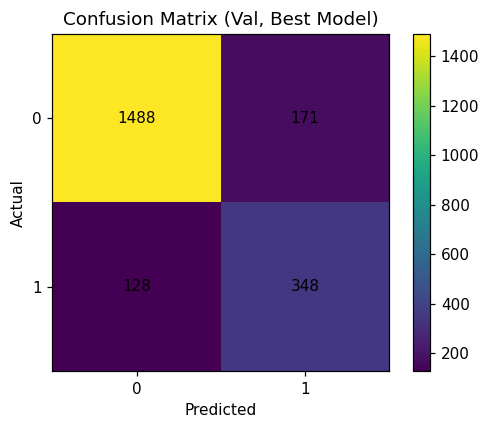

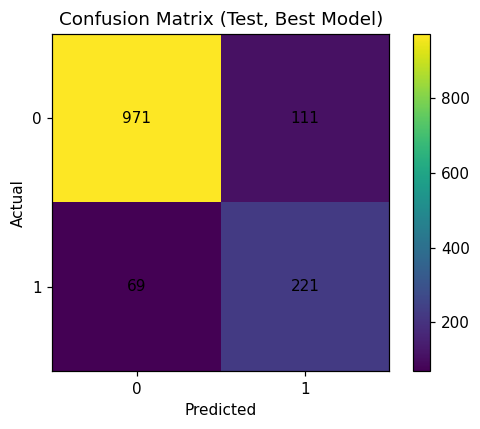

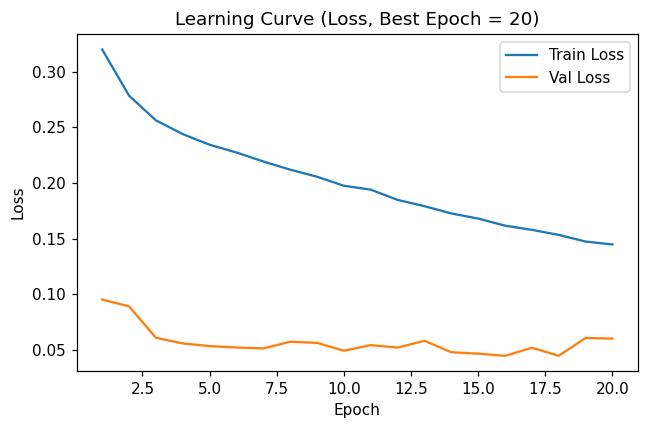

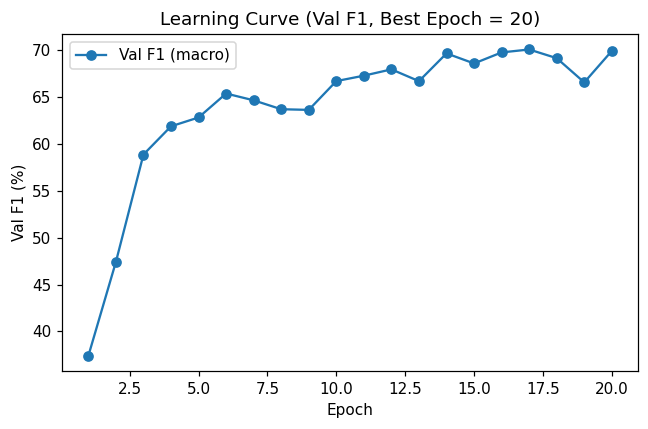

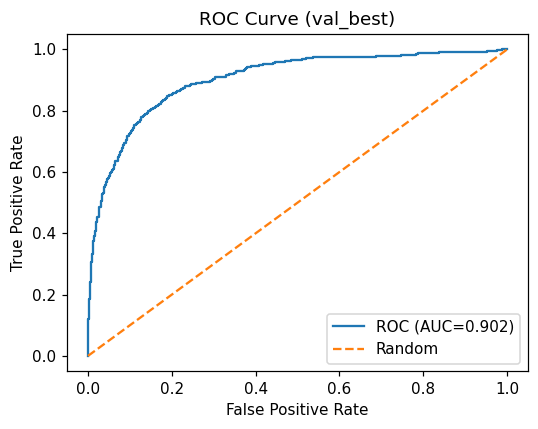

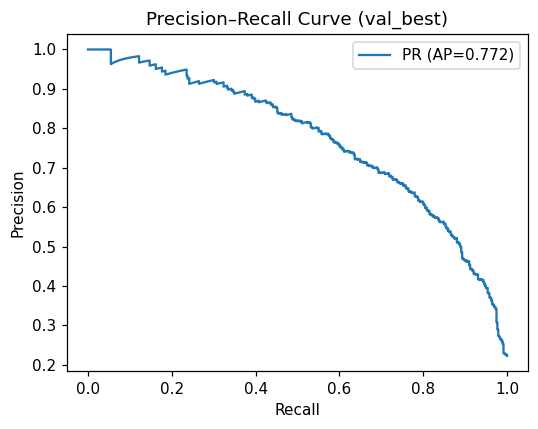

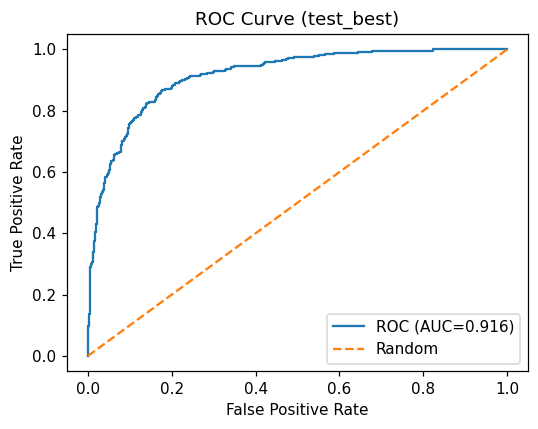

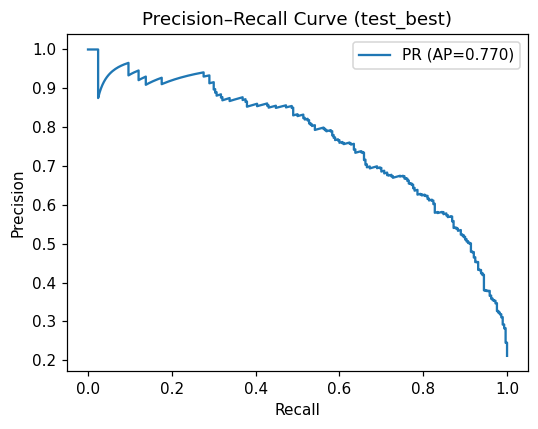

In [ ]:
train_metrics_best, ytr_best, ptr_best, str_best = evaluate(model, dl_train_eval, device)
val_metrics_best,   yv_best,  pv_best,  sv_best  = evaluate(model, dl_val,        device)
test_metrics_best,  yt_best,  pt_best,  st_best  = evaluate(model, dl_test,       device)

train_pct = {k: round(v * 100, 3) for k, v in train_metrics_best.items()}
val_pct   = {k: round(v * 100, 3) for k, v in val_metrics_best.items()}
test_pct  = {k: round(v * 100, 3) for k, v in test_metrics_best.items()}

print("\n[Best model @ Train]")
print("Accuracy (%)        :", train_pct["acc"])
print("Precision (%)       :", train_pct["prec"])
print("Recall (%)          :", train_pct["rec"])
print("F1-Score (%)        :", train_pct["f1"])
print("Specificity (%)     :", train_pct["spec"])
print("ROC-AUC (%)         :", train_pct["roc_auc"])
print("Precision-recall (%):", train_pct["pr_auc"])

print("\n[Best model @ Val]")
print("Accuracy (%)        :", val_pct["acc"])
print("Precision (%)       :", val_pct["prec"])
print("Recall (%)          :", val_pct["rec"])
print("F1-Score (%)        :", val_pct["f1"])
print("Specificity (%)     :", val_pct["spec"])
print("ROC-AUC (%)         :", val_pct["roc_auc"])
print("Precision-recall (%):", val_pct["pr_auc"])

print("\n[Best model @ Test]")
print("Accuracy (%)        :", test_pct["acc"])
print("Precision (%)       :", test_pct["prec"])
print("Recall (%)          :", test_pct["rec"])
print("F1-Score (%)        :", test_pct["f1"])
print("Specificity (%)     :", test_pct["spec"])
print("ROC-AUC (%)         :", test_pct["roc_auc"])
print("Precision-recall (%):", test_pct["pr_auc"])

# confusion matrix
plot_confusion_matrix(
    ytr_best, ptr_best,
    out_path=os.path.join(OUT_DIR, "confmat_train_best.png"),
    title="Confusion Matrix (Train, Best Model)"
)

plot_confusion_matrix(
    yv_best, pv_best,
    out_path=os.path.join(OUT_DIR, "confmat_val_best.png"),
    title="Confusion Matrix (Val, Best Model)"
)

plot_confusion_matrix(
    yt_best, pt_best,
    out_path=os.path.join(OUT_DIR, "confmat_test_best.png"),
    title="Confusion Matrix (Test, Best Model)"
)

# learning curves
plot_learning_curves(
    history=history,
    best_epoch=best_epoch,
    out_dir=OUT_DIR,
    prefix="convnextv2_tiny_focal"
)

# roc/pr curves
plot_roc_pr(
    y_true=ytr_best,
    y_score=str_best,
    out_dir=OUT_DIR,
    prefix="train_best",
    roc_auc=train_metrics_best["roc_auc"],
    pr_auc=train_metrics_best["pr_auc"]
)

plot_roc_pr(
    y_true=yv_best,
    y_score=sv_best,
    out_dir=OUT_DIR,
    prefix="val_best",
    roc_auc=val_metrics_best["roc_auc"],
    pr_auc=val_metrics_best["pr_auc"]
)

plot_roc_pr(
    y_true=yt_best,
    y_score=st_best,
    out_dir=OUT_DIR,
    prefix="test_best",
    roc_auc=test_metrics_best["roc_auc"],
    pr_auc=test_metrics_best["pr_auc"]
)


In [50]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, average_precision_score
)

def sweep_thresholds(y_true, y_score, thresholds=None, sort_by="f1", verbose=True):
    y_true = np.asarray(y_true).astype(int).ravel()
    y_score = np.asarray(y_score).ravel()

    if thresholds is None:
        thresholds = np.linspace(0.05, 0.95, 19)

    results = []
    for t in thresholds:
        y_pred = (y_score >= t).astype(int)

        acc  = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec  = recall_score(y_true, y_pred, zero_division=0)
        f1   = f1_score(y_true, y_pred, zero_division=0)

        cm = confusion_matrix(y_true, y_pred)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            spec = tn / (tn + fp + 1e-8)
        else:
            spec = float("nan")

        results.append({
            "threshold": t,
            "acc": acc,
            "prec": prec,
            "rec": rec,
            "f1": f1,
            "spec": spec,
        })

    df_thr = pd.DataFrame(results)
    df_thr_sorted = df_thr.sort_values(sort_by, ascending=False).reset_index(drop=True)

    if verbose:
        print(f"\n=== Top 10 thresholds on val (sorted by {sort_by}) ===")
        tmp = df_thr_sorted.copy()
        for col in ["acc", "prec", "rec", "f1", "spec"]:
            tmp[col] = tmp[col] * 100.0
        print(tmp.head(10).to_string(index=False, 
                                     formatters={"threshold": "{:.3f}".format,
                                                 "acc": "{:.3f}".format,
                                                 "prec": "{:.3f}".format,
                                                 "rec": "{:.3f}".format,
                                                 "f1": "{:.3f}".format,
                                                 "spec": "{:.3f}".format}))

        best_row = df_thr_sorted.iloc[0]
        print("\nBest threshold on validation set (by {}):".format(sort_by))
        print(
            f"t = {best_row['threshold']:.3f}, "
            f"Acc={best_row['acc']*100:.3f}%, "
            f"Prec={best_row['prec']*100:.3f}%, "
            f"Rec={best_row['rec']*100:.3f}%, "
            f"F1={best_row['f1']*100:.3f}%, "
            f"Spec={best_row['spec']*100:.3f}%"
        )

    return df_thr_sorted

df_thr_val = sweep_thresholds(yv_best, sv_best, sort_by="f1", verbose=True)

best_t = df_thr_val.iloc[0]["threshold"]
print(f"\n>>> The best threshold on validation set: best_t = {best_t:.3f}")

yt = np.asarray(yt_best).astype(int).ravel()
st = np.asarray(st_best).ravel()

y_test_pred = (st >= best_t).astype(int)

test_acc  = accuracy_score(yt, y_test_pred)
test_prec = precision_score(yt, y_test_pred, zero_division=0)
test_rec  = recall_score(yt, y_test_pred, zero_division=0)
test_f1   = f1_score(yt, y_test_pred, zero_division=0)

cm_test = confusion_matrix(yt, y_test_pred)
if cm_test.shape == (2, 2):
    tn, fp, fn, tp = cm_test.ravel()
    test_spec = tn / (tn + fp + 1e-8)
else:
    test_spec = float("nan")

test_roc = roc_auc_score(yt, st)
test_pr  = average_precision_score(yt, st)

print(f"\n[Best threshold model @ Test (t={best_t:.3f})]")
print(f"Accuracy (%)        : {test_acc*100:.3f}")
print(f"Precision (%)       : {test_prec*100:.3f}")
print(f"Recall (%)          : {test_rec*100:.3f}")
print(f"F1-Score (%)        : {test_f1*100:.3f}")
print(f"Specificity (%)     : {test_spec*100:.3f}")
print(f"ROC-AUC (%)         : {test_roc*100:.3f}")
print(f"Precision-recall (%): {test_pr*100:.3f}")

y_val_pred = (np.asarray(sv_best) >= best_t).astype(int)
val_acc2  = accuracy_score(yv_best, y_val_pred)
val_prec2 = precision_score(yv_best, y_val_pred, zero_division=0)
val_rec2  = recall_score(yv_best, y_val_pred, zero_division=0)
val_f12   = f1_score(yv_best, y_val_pred, zero_division=0)

print(f"\n[Best threshold model @ Val (t={best_t:.3f})]")
print(f"Accuracy (%)        : {val_acc2*100:.3f}")
print(f"Precision (%)       : {val_prec2*100:.3f}")
print(f"Recall (%)          : {val_rec2*100:.3f}")
print(f"F1-Score (%)        : {val_f12*100:.3f}")




=== Top 10 thresholds on val (sorted by f1) ===
threshold    acc   prec    rec     f1   spec
    0.500 85.995 67.052 73.109 69.950 89.693
    0.450 85.199 63.937 77.101 69.905 87.523
    0.550 86.464 69.851 69.118 69.483 91.441
    0.400 83.934 60.539 80.252 69.015 84.991
    0.600 86.651 73.012 63.655 68.013 93.249
    0.350 82.389 57.267 82.773 67.698 82.278
    0.300 81.218 55.074 85.504 66.996 79.988
    0.650 86.838 77.008 58.403 66.428 94.997
    0.250 78.923 51.601 88.025 65.062 76.311
    0.200 76.206 48.186 89.286 62.592 72.453

Best threshold on validation set (by f1):
t = 0.500, Acc=85.995%, Prec=67.052%, Rec=73.109%, F1=69.950%, Spec=89.693%

>>> The best threshold on validation set: best_t = 0.500

[Best threshold model @ Test (t=0.500)]
Accuracy (%)        : 86.880
Precision (%)       : 66.566
Recall (%)          : 76.207
F1-Score (%)        : 71.061
Specificity (%)     : 89.741
ROC-AUC (%)         : 91.611
Precision-recall (%): 76.975

[Best threshold model @ Val (t=0.5

In [ ]:
import pandas as pd

rows = [
    {
        "Split": "Train (Best)",
        "Accuracy (%)":         train_pct["acc"],
        "Precision (%)":        train_pct["prec"],
        "Recall (%)":           train_pct["rec"],
        "F1-Score (%)":         train_pct["f1"],
        "Specificity (%)":      train_pct["spec"],
        "ROC-AUC (%)":          train_pct["roc_auc"],
        "Precision-recall (%)": train_pct["pr_auc"],
    },
    {
        "Split": "Val (Best)",
        "Accuracy (%)":         val_pct["acc"],
        "Precision (%)":        val_pct["prec"],
        "Recall (%)":           val_pct["rec"],
        "F1-Score (%)":         val_pct["f1"],
        "Specificity (%)":      val_pct["spec"],
        "ROC-AUC (%)":          val_pct["roc_auc"],
        "Precision-recall (%)": val_pct["pr_auc"],
    },
    {
        "Split": "Test (Best)",
        "Accuracy (%)":         test_pct["acc"],
        "Precision (%)":        test_pct["prec"],
        "Recall (%)":           test_pct["rec"],
        "F1-Score (%)":         test_pct["f1"],
        "Specificity (%)":      test_pct["spec"],
        "ROC-AUC (%)":          test_pct["roc_auc"],
        "Precision-recall (%)": test_pct["pr_auc"],
    },
]

df_best = pd.DataFrame(rows)
print(df_best)

df_best.to_csv(os.path.join(OUT_DIR, "best_train_val_test_metrics_convnextv2.csv"), index=False, model="w")


         Split  Accuracy (%)  Precision (%)  Recall (%)  F1-Score (%)  \
0   Val (Best)        85.995         67.052      73.109        69.950   
1  Test (Best)        86.880         66.566      76.207        71.061   

   Specificity (%)  ROC-AUC (%)  Precision-recall (%)  
0           89.693       90.227                77.157  
1           89.741       91.611                76.975  
